# MNIST CNN scale invariance problem
Definitions section and data download

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchsummary import summary
from torchvision import datasets, transforms
import time
import numpy as np
import pandas as pd
import math
import seaborn as sns

Function defintion to get the accuracy of a bundle set of images and labels:

In [491]:
"""
    Simple function to bundle a set of images. Output has the same format required to use the trained model
"""
def image_bundle(images_labels, batch = -1):
    return torch.utils.data.DataLoader(images_labels, batch_size = len(images_labels) if batch==-1 else batch)

"""
    Input: bundle set of images created with torch.utils.data.DataLoader
    Output: accuracy percent of the trained model baed on the input set of images
"""
def images_accuracy(bundle_data, print_result=False):
    prediction_errors = {}
    model.eval()
    with torch.no_grad():
        correct = 0
        total = float(0)
        for images, labels in bundle_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Selecting errors to display
            error = (predicted != labels)
            for i in range(error.sum()):
                prediction_errors[len(prediction_errors)] = {'image': images[error][i].cpu().numpy(), 'label': labels[error][i].item(), 'predicted': predicted[error][i].item()}
        if print_result:
            print('Test Accuracy of the model on the {} test images: {} %'.format(int(total), (correct / total) * 100))
        return {'images_number': int(total), 'labeled_correct': correct, 'percent': (correct / total) * 100, 'predicting_errors': prediction_errors}
    
"""
    Function to scale the image array based on the scale value. The output image has size 28x28 by default
"""
from __future__ import division

def image_scaling(img, scale=1, output_size=28, show=False, return_tensor=True):
    min_zero = img.min()
    img_tmp = Image.fromarray(img)
    size = scale * np.array(img_tmp.size)
    img_tmp = img_tmp.resize(tuple(size.astype(int)))
    center, sq = (np.array(img_tmp.size) / 2).astype(int), int(output_size / 2)
    img_tmp = img_tmp.crop((center[0] - sq, center[1] - sq, output_size + center[0] - sq, output_size + center[1] - sq))
    img_tmp = np.array(img_tmp)
    img_tmp[img_tmp == 0] = min_zero
    if show:
        plt.imshow(img_tmp, cmap='gray')
    if return_tensor:
        return torch.tensor(img_tmp).reshape(1, output_size, output_size)
    else:
        return img_tmp

Hyperparameters definitions:

In [82]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

Downloading the data set, then images are packed in blocks (or batches) based on the parameter defined above in order to reduce the computation load.

In [86]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=trans, download=True)
train_loader = image_bundle(train_dataset, batch=batch_size)
test_loader = image_bundle(test_dataset, batch=batch_size)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print('Images for training: {}, images for testing: {}'.format(len(train_dataset), len(test_dataset)))

Images for training: 60000, images for testing: 10000


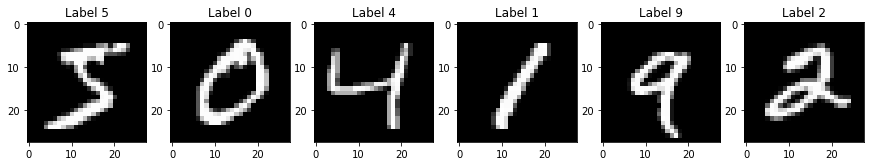

In [87]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target.item()))

## CNN model and optimization definition:

In [88]:
class ConvNet(nn.Module):
    def __init__(self, parallel = False):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        if parallel:
            self.layer1 = nn.DataParallel(self.layer1)
            self.layer2 = nn.DataParallel(self.layer2)
    
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
    # Function to print out the intermediate values for an input image
    def return_steps(self, x):
        cnv1 = self.layer1(x)
        cnv2 = self.layer2(cnv1)
        cnv3 = cnv2.reshape(cnv2.size(0), -1)
        lfc1 = self.fc1(cnv3)
        lfc2 = self.fc2(lfc1)
        lfc3 = self.fc3(lfc2)
        return cnv1, cnv2, cnv3, lfc1, lfc2, lfc3
        

model = ConvNet(parallel=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/henry/.local/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/home/henry/.local/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [89]:
summary(model, (1, 28, 28), 1, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 24, 24]             156
            Conv2d-2             [1, 6, 24, 24]             156
         MaxPool2d-3             [1, 6, 12, 12]               0
         MaxPool2d-4             [1, 6, 12, 12]               0
      DataParallel-5             [1, 6, 12, 12]               0
            Conv2d-6              [1, 16, 8, 8]           2,416
            Conv2d-7              [1, 16, 8, 8]           2,416
         MaxPool2d-8              [1, 16, 4, 4]               0
         MaxPool2d-9              [1, 16, 4, 4]               0
     DataParallel-10              [1, 16, 4, 4]               0
          Dropout-11                   [1, 256]               0
           Linear-12                   [1, 120]          30,840
           Linear-13                   [1, 100]          12,100
           Linear-14                   

## Training the model and test validation:

In [90]:
time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(train_loader), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

Epoch [1/5], Step [200/600], Loss: 0.4107, Accuracy: 88.00%
Epoch [1/5], Step [400/600], Loss: 0.2695, Accuracy: 91.00%
Epoch [1/5], Step [600/600], Loss: 0.3863, Accuracy: 93.00%
Epoch [2/5], Step [200/600], Loss: 0.1916, Accuracy: 92.00%
Epoch [2/5], Step [400/600], Loss: 0.2148, Accuracy: 94.00%
Epoch [2/5], Step [600/600], Loss: 0.3298, Accuracy: 94.00%
Epoch [3/5], Step [200/600], Loss: 0.1011, Accuracy: 94.00%
Epoch [3/5], Step [400/600], Loss: 0.1801, Accuracy: 93.00%
Epoch [3/5], Step [600/600], Loss: 0.3749, Accuracy: 95.00%
Epoch [4/5], Step [200/600], Loss: 0.1000, Accuracy: 93.00%
Epoch [4/5], Step [400/600], Loss: 0.1040, Accuracy: 99.00%
Epoch [4/5], Step [600/600], Loss: 0.3933, Accuracy: 95.00%
Epoch [5/5], Step [200/600], Loss: 0.1036, Accuracy: 96.00%
Epoch [5/5], Step [400/600], Loss: 0.0950, Accuracy: 97.00%
Epoch [5/5], Step [600/600], Loss: 0.3744, Accuracy: 96.00%
Training time (in seconds): 36.85


Text(0.5,1,'Accuracy')

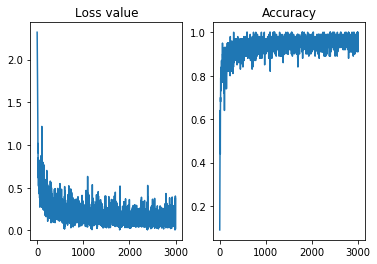

In [91]:
f, axarr = plt.subplots(1, 2)
axarr[0].plot(loss_list)
axarr[0].set_title('Loss value')
axarr[1].plot(acc_list)
axarr[1].set_title('Accuracy')

## Testing the trained model for different images scales:

Script to classify the testing dataset per label. The output is a dictionary of lists of tuples, where each element is the image and its label. Individual dictionaries are created for each group of scaled images.

In [416]:
data = list(test_dataset)
test_grouped, test_grouped_1_2, test_grouped_1_3, test_grouped_2, test_grouped_3 = {}, {},{}, {}, {}    
data_1_2, data_1_3, data_2, data_3 = [], [], [], []
for i in range(len(data)):
    label = data[i][1]
    image = data[i][0].reshape(28, 28).numpy()
    info = (image_scaling(image, scale=1/2), label)
    data_1_2.append(info)
    info = (image_scaling(image, scale=1/3), label)
    data_1_3.append(info)
    info = (image_scaling(image, scale=2), label)
    data_2.append(info)
    info = (image_scaling(image, scale=3), label)
    data_3.append(info)
    label = label.item()
    if label in test_grouped:
        test_grouped[label].append(data[i])
        test_grouped_1_2[label].append(data_1_2[i])
        test_grouped_1_3[label].append(data_1_3[i])
        test_grouped_2[label].append(data_2[i])
        test_grouped_3[label].append(data_3[i])
    else:
        test_grouped[label] = [data[i]]
        test_grouped_1_2[label] = [data_1_2[i]]
        test_grouped_1_3[label] = [data_1_3[i]]
        test_grouped_2[label] = [data_2[i]]
        test_grouped_3[label] = [data_3[i]]

Text(0.5,1,'label: 2, scale: 3')

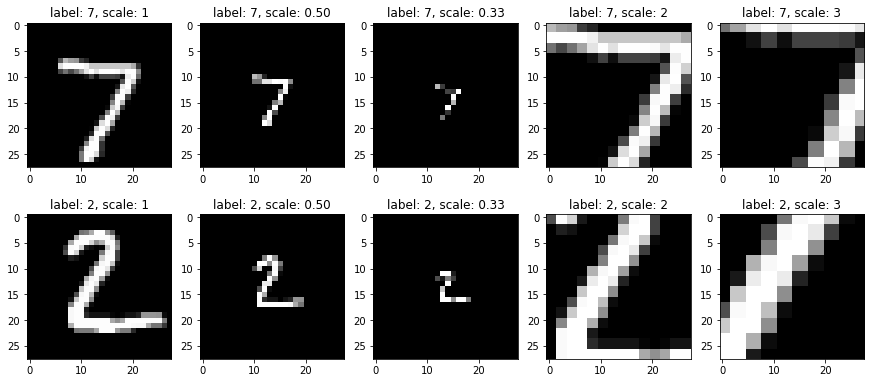

In [454]:
# Scaled images example:
fig = plt.figure(figsize=(15, 10))

plt.subplot(3, 5, 1)
plt.imshow(data[0][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[0][1].item(), 1))
plt.subplot(3, 5, 2)
plt.imshow(data_1_2[0][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {:,.2f}'.format(data[0][1].item(), 1/2))
plt.subplot(3, 5, 3)
plt.imshow(data_1_3[0][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {:,.2f}'.format(data[0][1].item(), 1/3))
plt.subplot(3, 5, 4)
plt.imshow(data_2[0][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[0][1].item(), 2))
plt.subplot(3, 5, 5)
plt.imshow(data_3[0][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[0][1].item(), 3))

plt.subplot(3, 5, 6)
plt.imshow(data[1][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[1][1].item(), 1))
plt.subplot(3, 5, 7)
plt.imshow(data_1_2[1][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {:,.2f}'.format(data[1][1].item(), 1/2))
plt.subplot(3, 5, 8)
plt.imshow(data_1_3[1][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {:,.2f}'.format(data[1][1].item(), 1/3))
plt.subplot(3, 5, 9)
plt.imshow(data_2[1][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[1][1].item(), 2))
plt.subplot(3, 5, 10)
plt.imshow(data_3[1][0].reshape(28, 28), cmap='gray')
plt.title('label: {}, scale: {}'.format(data[1][1].item(), 3))

## Layers comparison for different scale images:

In [648]:
out_1 = model.return_steps(data[0][0].reshape(1, 1, 28, 28))
out_1_2 = model.return_steps(data_1_2[0][0].reshape(1, 1, 28, 28))
out_1_3 = model.return_steps(data_1_3[0][0].reshape(1, 1, 28, 28))
out_2 = model.return_steps(data_2[0][0].reshape(1, 1, 28, 28))
out_3 = model.return_steps(data_3[0][0].reshape(1, 1, 28, 28))

dif_1_2 = out_1[0].reshape(6, 12, 12) - out_1_2[0].reshape(6, 12, 12)
dif_1_3 = out_1[0].reshape(6, 12, 12) - out_1_3[0].reshape(6, 12, 12)
dif_2 = out_1[0].reshape(6, 12, 12) - out_2[0].reshape(6, 12, 12)
dif_3 = out_1[0].reshape(6, 12, 12) - out_3[0].reshape(6, 12, 12)

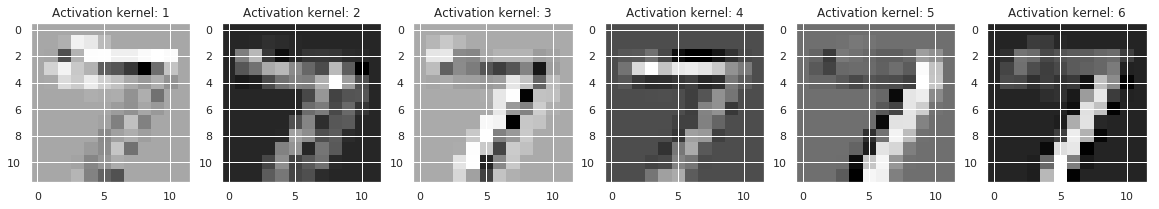

In [639]:
out_tmp = out_1[0].squeeze()
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Activation kernel: {}'.format(i+1))

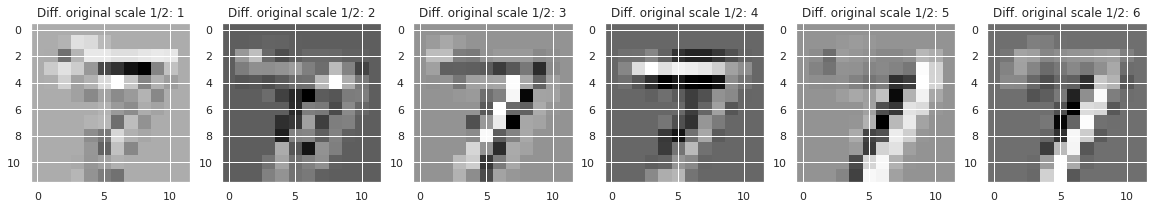

In [612]:
out_tmp = dif_1_2
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Diff. original scale 1/2: {}'.format(i+1))

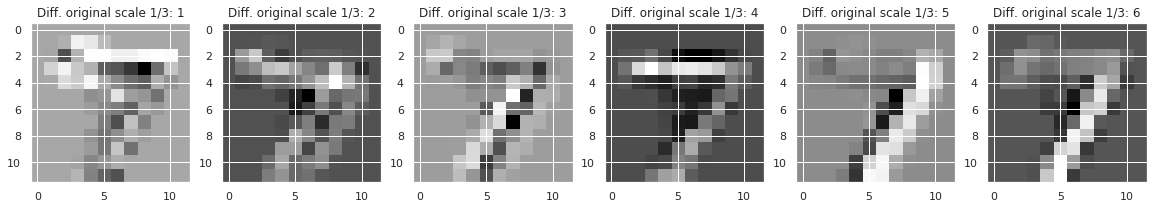

In [613]:
out_tmp = dif_1_3
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Diff. original scale 1/3: {}'.format(i+1))

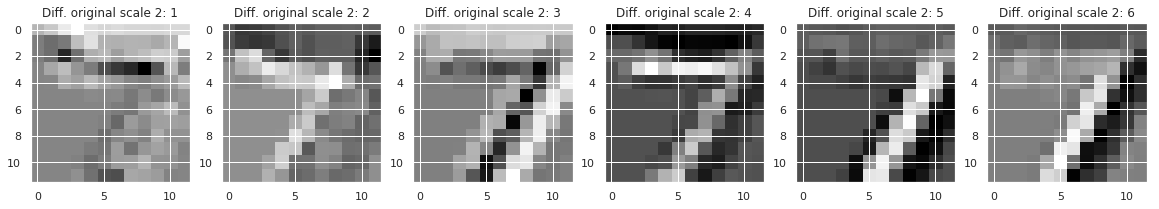

In [615]:
out_tmp = dif_2
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Diff. original scale 2: {}'.format(i+1))

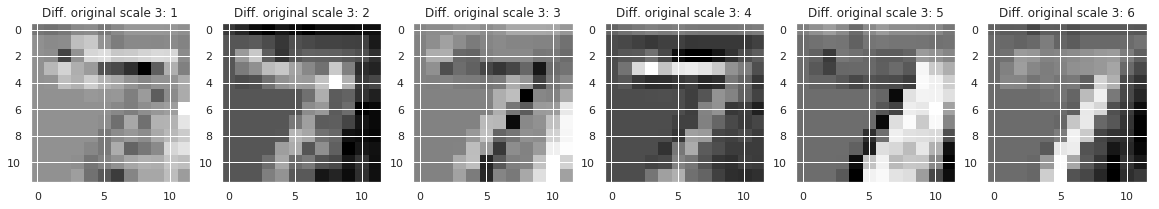

In [616]:
out_tmp = dif_3
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Diff. original scale 3: {}'.format(i+1))

In [650]:
difference_1_2 = torch.norm(dif_1_2.view(6, -1), p=2, dim=1).detach().cpu().numpy()
difference_1_3 = torch.norm(dif_1_3.view(6, -1), p=2, dim=1).detach().cpu().numpy()
difference_2 = torch.norm(dif_2.view(6, -1), p=2, dim=1).detach().cpu().numpy()
difference_3 = torch.norm(dif_3.view(6, -1), p=2, dim=1).detach().cpu().numpy()

difference_summary = pd.DataFrame({'Diff orig & scale 1/2': difference_1_2, 'Diff orig & scale 1/3': difference_1_3, 'Diff orig & scale 2': difference_2, 'Diff orig & scale 3': difference_3, 'Layer': ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6']})
difference_summary = difference_summary.set_index('Layer')

Text(0.5,1,'Frobenius norm of the difference per layer - input label 7')

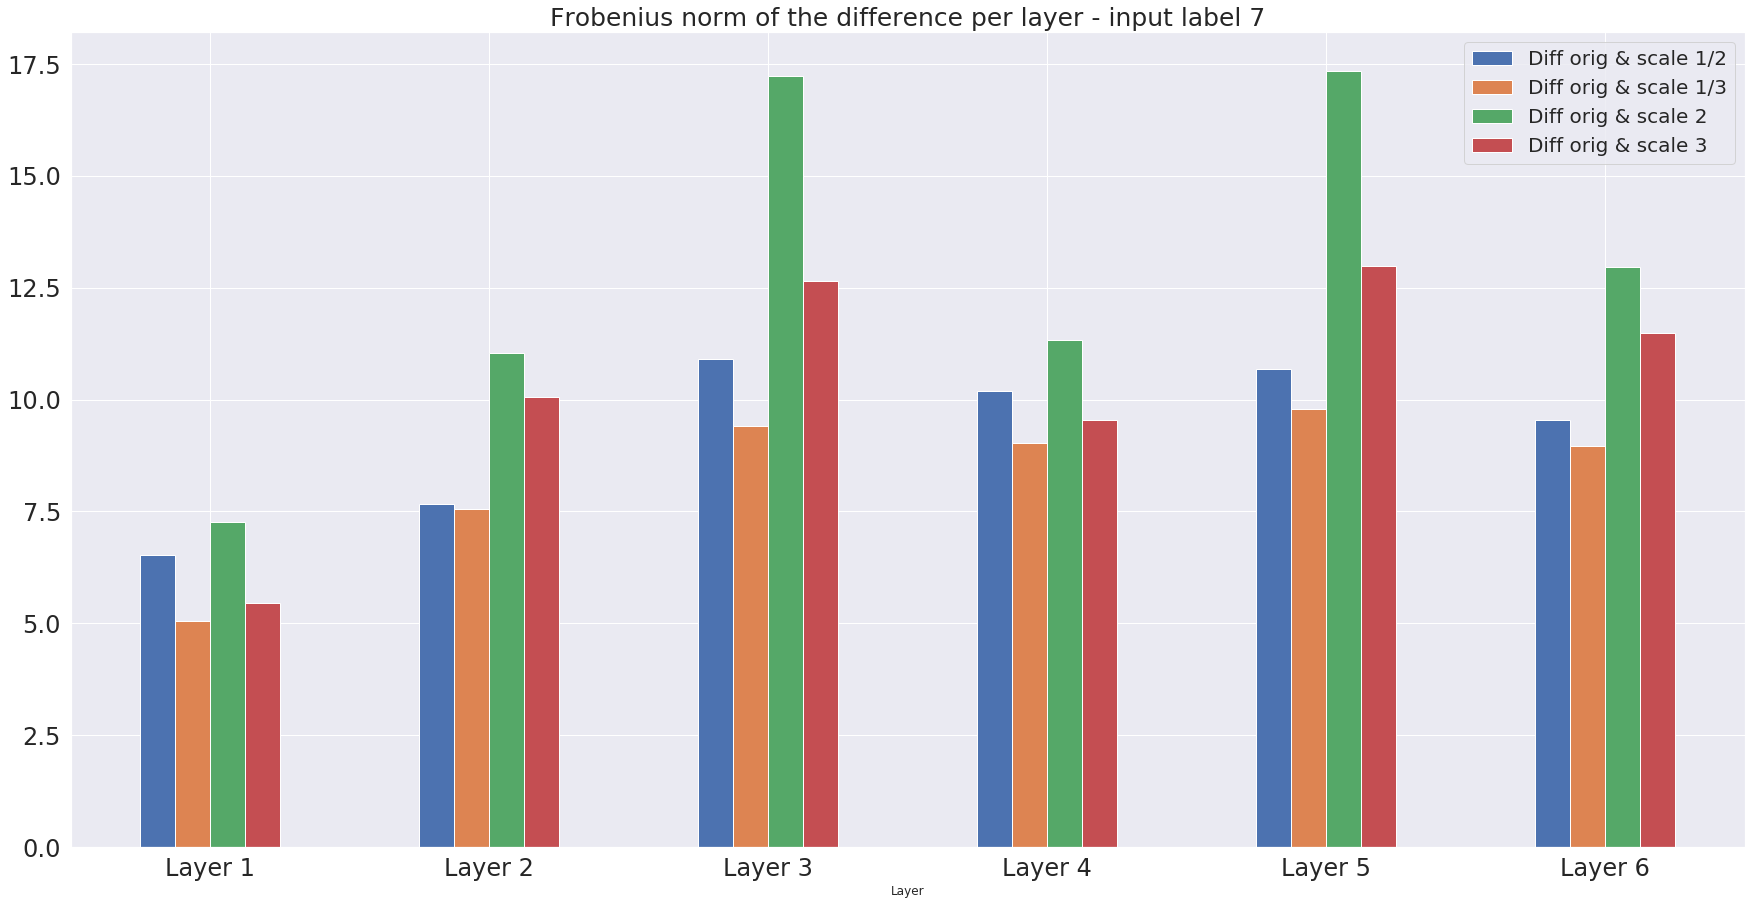

In [665]:
ax = difference_summary.plot.bar(rot=0, figsize=(30, 15), fontsize=24)
# ax = test_accuracy.plot.bar(rot=0, figsize=(30, 15), fontsize=24)
plt.legend(fontsize=20)
plt.title('Frobenius norm of the difference per layer - input label 7', fontsize=25)

Accuracy summary for total test data and per group label:

In [499]:
# Total test data
test_accuracy = pd.DataFrame({'x1': images_accuracy(image_bundle(data))['percent'], 'x1/2': images_accuracy(image_bundle(data_1_2))['percent'], 'x1/3': images_accuracy(image_bundle(data_1_3))['percent'], 'x2': images_accuracy(image_bundle(data_2))['percent'], 'x3': images_accuracy(image_bundle(data_3))['percent']}, index=['Total set'])

# Test accuracy per labal
for i in range(10):
    accr_tmp = pd.Series({'x1': images_accuracy(image_bundle(test_grouped[i]))['percent'], 'x1/2': images_accuracy(image_bundle(test_grouped_1_2[i]))['percent'], 'x1/3': images_accuracy(image_bundle(test_grouped_1_3[i]))['percent'], 'x2': images_accuracy(image_bundle(test_grouped_2[i]))['percent'], 'x3': images_accuracy(image_bundle(test_grouped_3[i]))['percent']}, name='label {}'.format(i))
    test_accuracy = test_accuracy.append(accr_tmp)

In [500]:
test_accuracy

,x1,x1/2,x1/3,x2,x3
Total set,97.610000,39.780000,12.850000,42.320000,22.980000
label 0,98.877551,0.000000,0.000000,11.632653,0.816327
label 1,99.030837,99.207048,99.911894,83.171806,32.951542
label 2,97.965116,37.015504,0.000000,37.984496,25.290698
label 3,97.722772,18.316832,0.000000,4.653465,2.079208
label 4,97.046843,70.162933,5.397149,42.362525,6.211813
label 5,97.982063,71.188341,10.986547,11.547085,5.941704
label 6,97.181628,0.521921,0.000000,72.129436,52.505219
label 7,95.428016,36.284047,0.000000,61.089494,20.622568
label 8,98.562628,3.490760,0.000000,58.008214,66.119097


Text(0.5,1,'Error accuracy per category')

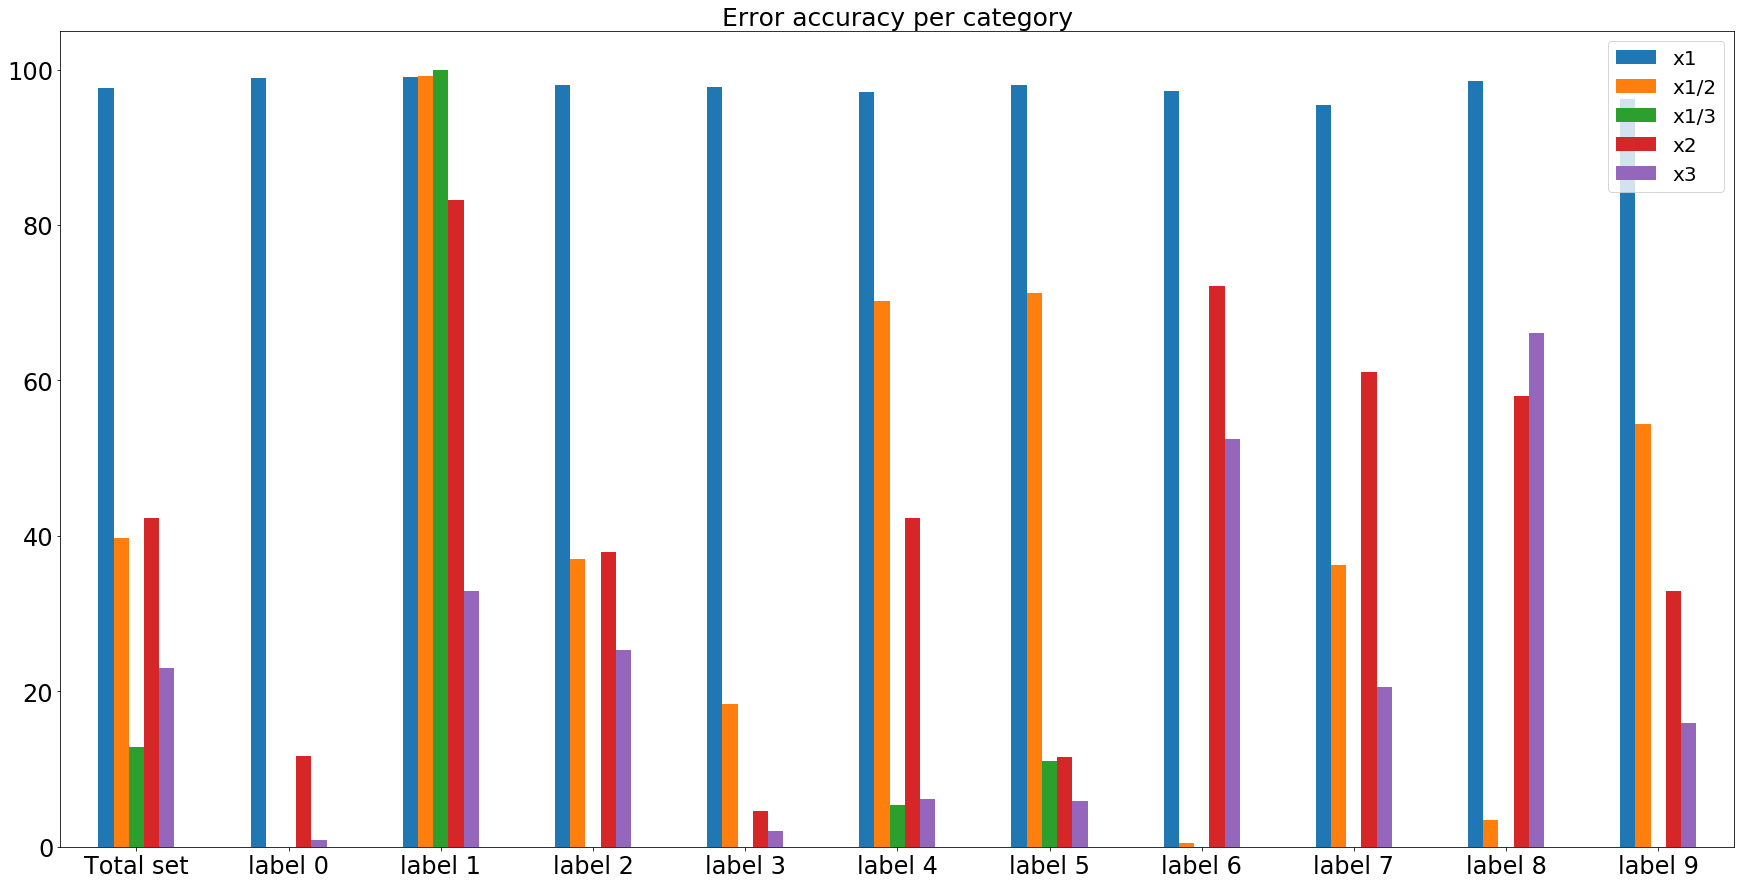

In [507]:
ax = test_accuracy.plot.bar(rot=0, figsize=(30, 15), fontsize=24)
plt.legend(fontsize=20)
plt.title('Error accuracy per category', fontsize=25)

# Bootstrap approach:

Text(0.5,1,'Accuracy distribution estimate for test data (scale=1), n=500')

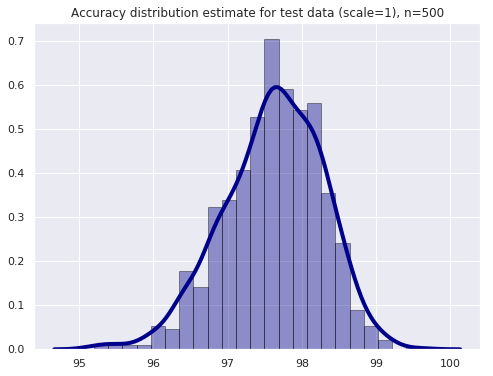

In [562]:
sns.set(rc={'figure.figsize':(8,6)})
import random
n = 500
total_set = []
for _ in range(1000):
    total_set.append(images_accuracy(image_bundle([data[i] for i in random.sample(range(len(data)), n)], batch=n))['percent'])
sns.distplot(total_set, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title('Accuracy distribution estimate for test data (scale=1), n=500')

Text(0.5,1,'Accuracy distribution estimate for test data (scale=1/2), n=500')

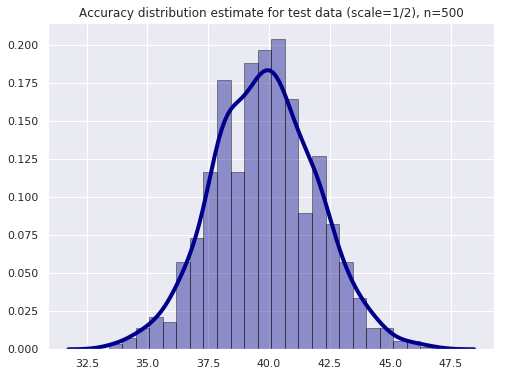

In [563]:
total_set = []
for i in range(1000):
    total_set.append(images_accuracy(image_bundle([data_1_2[i] for i in random.sample(range(len(data)), n)], batch=n))['percent'])
sns.distplot(total_set, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title('Accuracy distribution estimate for test data (scale=1/2), n=500')

Text(0.5,1,'Accuracy distribution estimate for test data (scale=1/3), n=500')

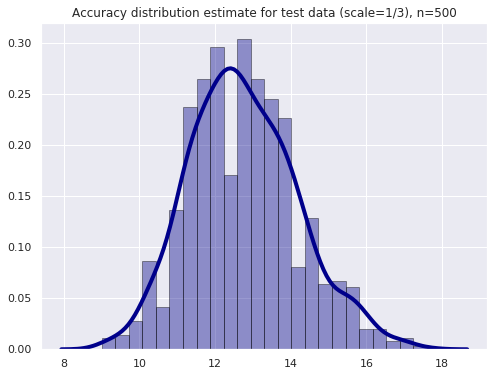

In [564]:
total_set = []
for i in range(1000):
    total_set.append(images_accuracy(image_bundle([data_1_3[i] for i in random.sample(range(len(data)), n)], batch=n))['percent'])
sns.distplot(total_set, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title('Accuracy distribution estimate for test data (scale=1/3), n=500')

Text(0.5,1,'Accuracy distribution estimate for test data (scale=2), n=500')

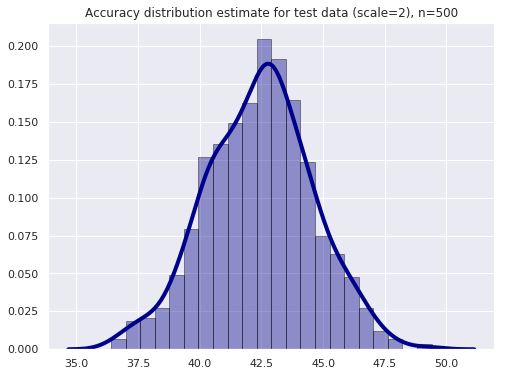

In [565]:
total_set = []
for i in range(1000):
    total_set.append(images_accuracy(image_bundle([data_2[i] for i in random.sample(range(len(data)), n)], batch=n))['percent'])
sns.distplot(total_set, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title('Accuracy distribution estimate for test data (scale=2), n=500')

Text(0.5,1,'Accuracy distribution estimate for test data (scale=3), n=500')

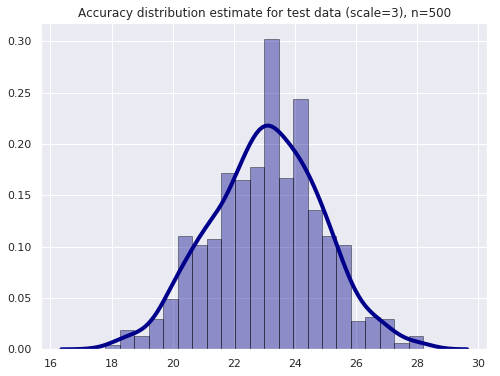

In [566]:
total_set = []
for i in range(1000):
    total_set.append(images_accuracy(image_bundle([data_3[i] for i in random.sample(range(len(data)), n)], batch=n))['percent'])
sns.distplot(total_set, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title('Accuracy distribution estimate for test data (scale=3), n=500')